In [1]:
import fastai
import torch
import torchvision
import os

In [2]:
os.getcwd()

'/home/kaja/Projects/rotation'

In [3]:
from PIL import Image 
from PIL import ImageFilter 
import os 

## Create Dataset from downloaded jpgs

In [44]:
# Crop, create rotate 0
raw_path ="data/raw/cano"
out_path ="data/cano/rotate0"
if not os.path.isdir(out_path): os.mkdir(out_path)

for p in os.listdir(raw_path):   
    img = Image.open(os.path.join(raw_path, p)) 
    img.crop((100,100,1200,1200)).save(os.path.join(out_path, p)) 

In [45]:
# Create rotated images 
def rotate(in_path = "data/cano/rotate0", out_path = "data/cano/rotate90",rotation=90):
    if not os.path.isdir(out_path): os.mkdir(out_path)
    for p in os.listdir(in_path):   
        img = Image.open(os.path.join(in_path, p)) 
        img.rotate(rotation).save(os.path.join(out_path, p)) 
rotate(in_path="data/cano/rotate0", out_path="data/cano/rotate90", rotation=90)
rotate(in_path="data/cano/rotate0", out_path="data/cano/rotate180", rotation=180)
rotate(in_path="data/cano/rotate0", out_path="data/cano/rotate270", rotation=270)

## Load Data

In [4]:
from fastai.vision.all import *

/home/kaja/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [27]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y = parent_label,
                 item_tfms=RandomResizedCrop(460, min_scale=0.6))
dls = dblock.dataloaders("data/houn")

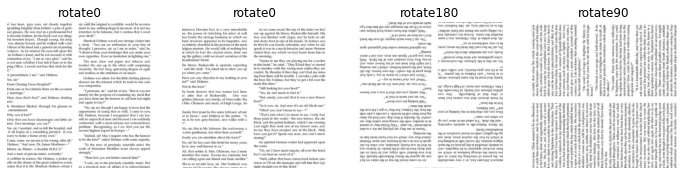

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

In [26]:
dblock.datasets("data/houn")

(#300) [(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0)),(PILImage mode=RGB size=1100x1100, TensorCategory(0))...]

## Train Model

In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.812143,1.417995,0.516667,02:01


epoch,train_loss,valid_loss,error_rate,time
0,1.340459,1.056228,0.383333,02:42


## Inspect learned model

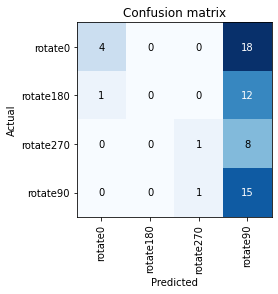

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

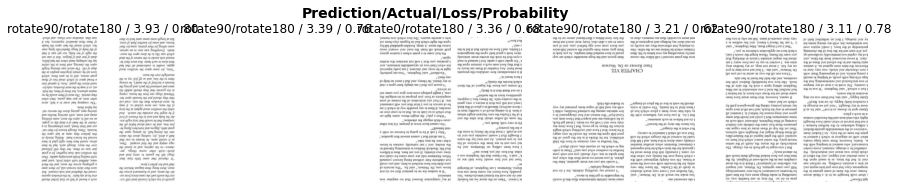

In [30]:
interp.plot_top_losses(5, nrows=1)

## Save model

In [31]:
learn.export()

## Use for inference

In [32]:
learn_inf = load_learner('export.pkl')

In [35]:
learn_inf.predict('data/cano/rotate90/Page_00002.png')

('rotate90', tensor(3), tensor([0.1516, 0.0493, 0.1232, 0.6759]))

In [36]:
learn_inf.dls.vocab

['rotate0', 'rotate180', 'rotate270', 'rotate90']

## User interface

In [38]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [40]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [41]:
pred,pred_idx,probs = learn_inf.predict(img)

In [43]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: rotate0; Probability: 0.7149')

In [44]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [46]:
btn_upload = widgets.FileUpload()

In [48]:
#hide_output
VBox([widgets.Label('Select your png!'), 
      btn_upload, btn_run, out_pl, lbl_pred])